<center>
    
    Online Recurrent Neural Networks
    
    Author: Daniel Coble
    
    Status: Work in progress
</center>

This notebook should go along side a document in which I discuss the best way to perform backpropagation and weight updating in an RNN which is being trained online. The algorithm performs backpropagation and forward pass at each step, so there is no break during which all of BPTT is calculated, it also uses a fixed memory size. In this notebook, I create a dataset for online training and a simple RNN to predict on it, trained with the online algorithm.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
# create dataset

dp = 200000 # number of points in dataset
T_range = (5, 30) # range of periods
L_range = (10, 100) # range of how long each period will last.

X = np.zeros((dp))
y = np.zeros((dp))

T_current = T_range[0] + np.random.rand()*(T_range[1] - T_range[0])
j = np.random.randint(L_range[0], high=L_range[1])
theta = 0
for i in range(dp):
    X[i] = np.sin(theta)
    y[i] = T_current
    theta += 2*np.pi/T_current
    j -= 1
    if(j == 0):
        T_current = T_range[0] + np.random.rand()*(T_range[1] - T_range[0])
        j = np.random.randint(L_range[0], high=L_range[1])

X = X.reshape(-1, 1)

Plot a random section of the dataset.

(0.0, 100.0)

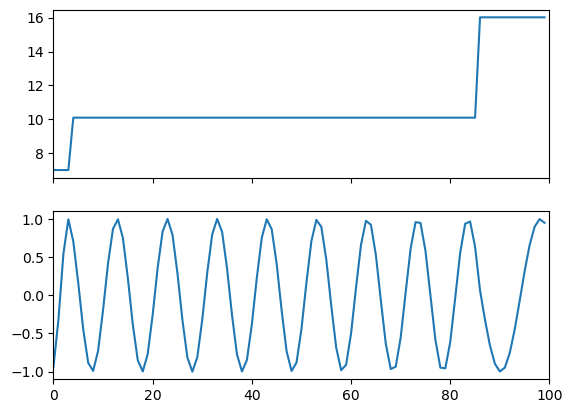

In [6]:
j = np.random.randint(0, high=dp-100)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(y[j:j+100])
ax2.plot(X[j:j+100])
ax2.set_xlim((0, 100))

Simultaneuos forward pass and training:

In [7]:
units = 50
epochs = 10
N = 100 # backpropagation length
lr = .01 # learning rate
# batches = dp//N
def sigmoid(x):
    return 1/(1+np.exp(-1*x))
def ddsigmoid(x):
    y = exp(-1*x)
    return y/(1+y)**2

# instantiate model
W = np.random.rand(units, 1)
U = np.random.rand(units, units)
b = np.random.rand(units, 1)
d = np.random.rand(1, units)

h_mat = np.zeros((units, N))
y_hat_mat = np.zeros((1, N))
y_mat = np.zeros((1, N)) # easier for keeping track of indices but not required
x_mat = np.zeros((1, N)) # easier for keeping track of indices but not required
h = np.zeros(units, 1)

for epoch in range(epochs):
    write_mode = True # true for forward, false for backward
    for i in range(0, N, dp): # i: current timestep
        if(write_mode):
            h_iter = range(0, N)
        else:
            h_iter = range(N, 0, -1)
        i_iter = range(i, i+N)
        
        de_dh_future = np.zeros(units, 1)
        
        delta_W = np.zeros(units, 1)
        delta_U = np.zeros(units, units)
        delta_b = np.zeros(units, 1)
        delta_d = np.zeros(1, units)
        for i, h_index in zip(i_iter, h_iter):
            # forward section
            x_ = X[:,i]
            y_ = y[i]
            
            h = sigmoid(W@x + U@h + b)
            y_hat = d@h
            
            # pop matrix elements before replacing them
            y_hat_bptt = y_hat_mat[h_index]
            y_bptt = y_mat[h_index]
            h_bptt = h_mat[:,h_index]
            x_bptt = x_mat[h_index]
            
            y_hat_mat[h_index] = y_hat
            y_mat[h_index] = y_
            h_mat[:,h_index] = h
            x_mat[h_index] = x_
            
            # backward section
            y_hat = y_hat_bptt
            y_ = y_bptt
            h = h_mat[:,h_index]
            x_ = x_bptt
            
            de_dy = -2/N*(y_ - y_hat)
            de_dh_current = d*de_dy
            de_dh = de_dh_current + de_dh_future
            de_dz = de_dh*(h - h**2)
            de_dW = x_@(de_dz.T)
            de_dU = h@(de_dz.T)
            de_dh_future = (U.T)@(de_dz)
            
            delta_W += de_dW
            delta_U += de_dU
        
        # weight updating
        W -= lr*delta_W
        U -= lr*delta_U
        b -= lr*delta_b
        d -= lr*delta_d

TypeError: Cannot interpret '1' as a data type